In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json 
import string
import sklearn
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2023-07-13 21:13:29.966754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
%%writefile content.json
{"intents":
    [
        {
            "tag": "greeting",
            "input": ["hello", "hi there!", "welcome!", "hey"],
            "responses": ["Hi, welcome to Laura's chatbot",
            "Hi! How can I help",
            "Hello there, what can I help you with today"
            ]
        },
        {
            "tag": "goodbye",
            "input": ["thank you", "thanks", "bye", "goodbye"],
            "responses": [
                "Thank you for using this chatbot. Farewell.",
                "Have a good day",
                "See you next time",
                "Goodbye"
            ]
        },
        {
            "tag": "workinfo",
            "input": ["tell me about your work history?", "previous employment", "previous jobs", "employment history"],
            "responses": ["Melbourne Marriott Hotel: guest services agent (2019-2022), Crown Resorts: Crystal CLub front desk agent (2022-current)", 
            "Hotels"]
        },
        {
            "tag": "university",
            "input": ["When do you graduate", "graduation", "What degree are you studying?"],
            "responses": ["I am studying a Bachelor of Computer Science at Monash University, graduating Dec 2024",
            "My graduation from Monash University's Bachelor of Computer Science will be in December 2024"]
        }
    ]
    }

Overwriting content.json


Now to import the dataset from the data in the json file using a pandas dataframe. The basic chatbot on this occasion only requires a small dataset as show above.

In [5]:
with open('content.json') as content:
    data1 = json.load(content)

In [6]:
# get data to lists
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

#convert to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})


In [7]:
#print data
data

,inputs,tags
0,hello,greeting
1,hi there!,greeting
2,welcome!,greeting
3,hey,greeting
4,thank you,goodbye
5,thanks,goodbye
6,bye,goodbye
7,goodbye,goodbye
8,tell me about your work history?,workinfo
9,previous employment,workinfo


Preprocessing:
We need to remove the punctuations, convert to lowercase and encode text/ numerical data to ensure no errors when processing

In [9]:
data['inputs'] = data['inputs'].apply(lambda wrd: [ltrs.lower() for wrd in wrd for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,welcome,greeting
3,hey,greeting
4,thank you,goodbye
5,thanks,goodbye
6,bye,goodbye
7,goodbye,goodbye
8,tell me about your work history,workinfo
9,previous employment,workinfo


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding output
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

Tokenizer assigns unique token to each word and padding gets all data to same length

In [12]:
input_shape = x_train.shape[1]
print(input_shape)

6


In [13]:
# define vocab

vocab = len(tokenizer.word_index)
print("num unique words: ", vocab)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

num unique words:  27
output length:  4


Neural Network

We will now use an embedding layer, giving the corresponding vector for each word in dataset.

In [14]:
#creating model

i = Input(shape=(input_shape,))
x = Embedding(vocab+1,10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation='softmax')(x)
model= Model(i,x)

In [15]:
#compiling model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


In [16]:
#training model
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 1.3833 - accuracy: 0.3333
Epoch 2/200
1/1 [==============================] - 0s 7ms/step - loss: 1.3823 - accuracy: 0.3333
Epoch 3/200
1/1 [==============================] - 0s 8ms/step - loss: 1.3813 - accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 9ms/step - loss: 1.3803 - accuracy: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 8ms/step - loss: 1.3793 - accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 1.3783 - accuracy: 0.3333
Epoch 7/200
1/1 [==============================] - 0s 10ms/step - loss: 1.3772 - accuracy: 0.3333
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 1.3761 - accuracy: 0.3333
Epoch 9/200
1/1 [==============================] - 0s 10ms/step - loss: 1.3750 - accuracy: 0.3333
Epoch 10/200
1/1 [==============================] - 0s 11ms/step - loss: 1.3739 - accuracy: 0.3333
Epoch 11/200
1/1 [========

Model Analysis

Plotting:

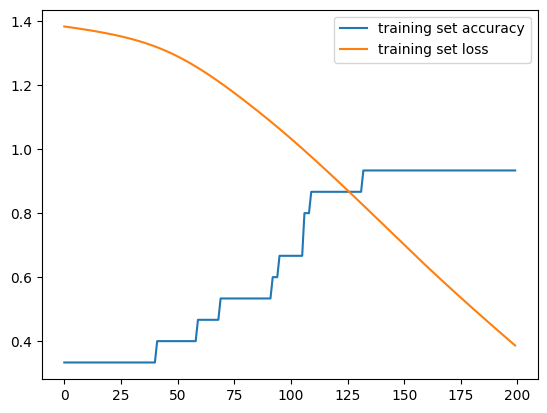

In [17]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.legend()

Testing:

Below we will test our model

In [21]:
#chatting
import random


while True:
    texts_p = []
    prediction_input = input('You : ')
    print("You: ", str(prediction_input))

    #remove punctuation and convert to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    #tokenize and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    #get output from model
    output = model.predict(prediction_input)
    output = output.argmax()

    #finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    print("LauraBot: ", random.choice(responses[response_tag]))
    if response_tag == "goodbye":
        break

You:  hello
1/1 [==============================] - 0s 21ms/step
LauraBot:  Hi! How can I help
You:  tell me about your work history?
1/1 [==============================] - 0s 21ms/step
LauraBot:  Melbourne Marriott Hotel: guest services agent (2019-2022), Crown Resorts: Crystal CLub front desk agent (2022-current)
You:  When do you graduate
1/1 [==============================] - 0s 22ms/step
LauraBot:  My graduation from Monash University's Bachelor of Computer Science will be in December 2024
You:  thank you
1/1 [==============================] - 0s 24ms/step
LauraBot:  Goodbye
